In [1]:
import numpy as np
import networkx as nx
from itertools import combinations
import random
import math
import matplotlib.pyplot as plt


def generate_block_network(block_sizes, prob_matrix):
    """Generate a stochastic block model (SBM) network."""
    num_blocks = len(block_sizes)
    G = nx.Graph()
    
    # Assign blocks
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            current_label += 1
    
    # Add edges based on probability matrix
    start_idx = 0
    for i in range(num_blocks):
        end_idx = start_idx + block_sizes[i]
        start_jdx = 0
        for j in range(num_blocks):
            end_jdx = start_jdx + block_sizes[j]
            for u in range(start_idx, end_idx):
                for v in range(start_jdx, end_jdx):
                    if u < v and np.random.rand() < prob_matrix[i][j]:
                        G.add_edge(u, v)
            start_jdx = end_jdx
        start_idx = end_idx
    
    return G


def modify_network(G, modification_fraction):
    """Randomly remove and add links to create the observed network A_O."""
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Remove edges
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Add edges
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v) and u != v:
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges


def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    return {node: node for node in G.nodes()}


def calculate_H(P, G):
    """Compute H(P) based on partition P."""
    if not P or not G:  # Handle empty inputs
        return 0

    block_counts = {}
    for node, group in P.items():
        block_counts.setdefault(group, []).append(node)

    lO = {}
    r = {}

    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1

    # Compute rαβ (max possible links between groups)
    for (g1, nodes1), (g2, nodes2) in combinations(block_counts.items(), 2):
        key = tuple(sorted([g1, g2]))
        r[key] = len(nodes1) * len(nodes2)

    # Handle self-links within the same group
    for g, nodes in block_counts.items():
        key = (g, g)
        r[key] = len(nodes) * (len(nodes) - 1) // 2

    # Compute H(P)
    H = sum(
        math.log(float(r[key] + 1)) +
        math.log(math.comb(r[key], lO.get(key, 0)))
        for key in r if r[key] > 0
    )

    return H


def metropolis_MCMC(G, num_samples):
    """Run MCMC sampling to estimate the partition distribution."""
    P = initialize_partition(G)
    partitions = []

    if not P or not G:
        raise ValueError("Partition or graph must not be empty.")

    for _ in range(num_samples):
        node = random.choice(list(G.nodes()))
        new_group = random.choice(list(P.values()))  # Move node to a random group

        # Compute ΔH
        old_H = calculate_H(P, G)
        original_group = P[node]
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H

        # Accept move with probability exp(-ΔH)
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = original_group  # Reject the move

        partitions.append(P.copy())

    return partitions


def estimate_link_reliability(G, partitions):
    """Compute R_L(i,j) for all possible links based on sampled partitions."""
    if not G or not partitions:
        raise ValueError("Graph G and partitions cannot be empty.")
    
    nodes = list(G.nodes())
    reliability = {}
    node_pair_agreement = {}

    # Precompute agreement counts for all node pairs
    for p in partitions:
        for u, v in combinations(nodes, 2):  # Consider all possible node pairs
            if p[u] == p[v]:
                node_pair_agreement[(u, v)] = node_pair_agreement.get((u, v), 0) + 1

    # Compute reliability for all possible links
    for u, v in combinations(nodes, 2):  # Iterate over all possible links
        lO = node_pair_agreement.get((u, v), 0)  # Times nodes are in the same group
        r = len(partitions)
        reliability[(u, v)] = (lO + 1) / (r + 2)  # Laplace smoothing

    return reliability

# Generate True Network (A_T)
block_sizes = [4, 4, 4]  # Three groups of 10 nodes each
prob_matrix = [[0.8, 0.2, 0.1], [0.2, 0.7, 0.15], [0.1, 0.15, 0.9]]
true_network = generate_block_network(block_sizes, prob_matrix)

# Create Observed Network (A_O)
observed_network, removed_edges, added_edges = modify_network(true_network, modification_fraction=0.2)

# Run MCMC Sampling
partitions = metropolis_MCMC(observed_network, num_samples=1000)

# Estimate Link Reliability
reliability = estimate_link_reliability(observed_network, partitions)

# Print all reliable links
print("Reliable Links and Their Scores:")
for edge, rl in sorted(reliability.items(), key=lambda x: x[1], reverse=True):
    print(f"Edge {edge}: Reliability {rl:.4f}")



Reliable Links and Their Scores:
Edge (7, 9): Reliability 0.9242
Edge (2, 8): Reliability 0.8902
Edge (3, 10): Reliability 0.8902
Edge (8, 10): Reliability 0.8892
Edge (2, 7): Reliability 0.8752
Edge (9, 11): Reliability 0.8733
Edge (10, 11): Reliability 0.8733
Edge (0, 8): Reliability 0.8723
Edge (0, 10): Reliability 0.8713
Edge (3, 8): Reliability 0.8703
Edge (3, 9): Reliability 0.8703
Edge (3, 11): Reliability 0.8703
Edge (3, 6): Reliability 0.8563
Edge (7, 11): Reliability 0.8563
Edge (7, 8): Reliability 0.8543
Edge (2, 3): Reliability 0.8533
Edge (6, 10): Reliability 0.8533
Edge (9, 10): Reliability 0.8513
Edge (6, 8): Reliability 0.8483
Edge (2, 10): Reliability 0.8473
Edge (8, 11): Reliability 0.8463
Edge (0, 9): Reliability 0.8413
Edge (2, 11): Reliability 0.8413
Edge (8, 9): Reliability 0.8393
Edge (3, 7): Reliability 0.8363
Edge (7, 10): Reliability 0.8363
Edge (2, 9): Reliability 0.8333
Edge (1, 6): Reliability 0.8283
Edge (0, 7): Reliability 0.8253
Edge (1, 2): Reliability 

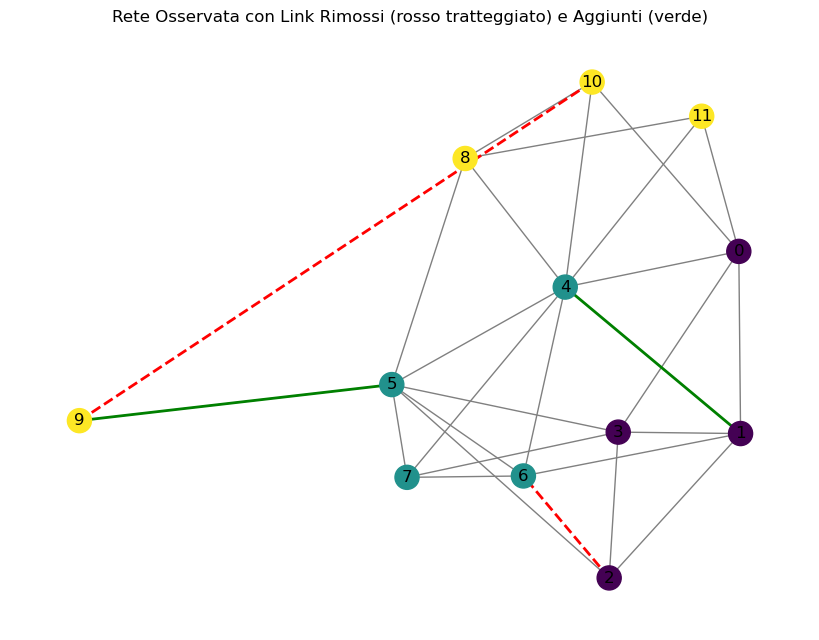

In [2]:
def plot_modified_network(G, removed_edges, added_edges):
    """Plotta la rete osservata con rimozioni e aggiunte evidenziate."""
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=[G.nodes[n]['block'] for n in G.nodes()], edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2)
    plt.title("Rete Osservata con Link Rimossi (rosso tratteggiato) e Aggiunti (verde)")
    plt.show()

plot_modified_network(observed_network, removed_edges, added_edges)

In [3]:
def calculate_accuracy(true_network, observed_network, reliability):
    """Calculate accuracy for missing and spurious interactions based on ranking comparisons."""
    
    # Identify edge sets
    true_negatives = set(observed_network.edges()) - set(true_network.edges())  # AO_ij = 0, AT_ij = 0
    false_negatives = set(true_network.edges()) - set(observed_network.edges())  # AO_ij = 0, AT_ij = 1
    true_positives = set(observed_network.edges()) & set(true_network.edges())  # AO_ij = 1, AT_ij = 1
    false_positives = set(observed_network.edges()) - set(true_network.edges())  # AO_ij = 1, AT_ij = 0

    # Rank edges by reliability (higher reliability = higher rank)
    ranked_edges = sorted(reliability.items(), key=lambda x: x[1], reverse=True)
    edge_ranks = {edge: rank for rank, (edge, _) in enumerate(ranked_edges)}

    # Compute missing interaction accuracy: P(FN rank > TN rank)
    if false_negatives and true_negatives:
        count_correct = sum(1 for fn in false_negatives for tn in true_negatives if edge_ranks[fn] < edge_ranks[tn])
        missing_accuracy = count_correct / (len(false_negatives) * len(true_negatives))
    else:
        missing_accuracy = 1  # Undefined case when there are no FN or TN

    # Compute spurious interaction accuracy: P(FP rank < TP rank)
    if false_positives and true_positives:
        count_correct = sum(1 for fp in false_positives for tp in true_positives if edge_ranks[fp] > edge_ranks[tp])
        spurious_accuracy = count_correct / (len(false_positives) * len(true_positives))
    else:
        spurious_accuracy = 1  # Undefined case when there are no FP or TP

    return missing_accuracy, spurious_accuracy

# Calculate Accuracy
missing_accuracy, spurious_accuracy = calculate_accuracy(true_network, observed_network, reliability)

# Print Results
print(f"Missing Interaction Accuracy: {missing_accuracy:.4f}")
print(f"Spurious Interaction Accuracy: {spurious_accuracy:.4f}")


Missing Interaction Accuracy: 1.0000
Spurious Interaction Accuracy: 0.7292


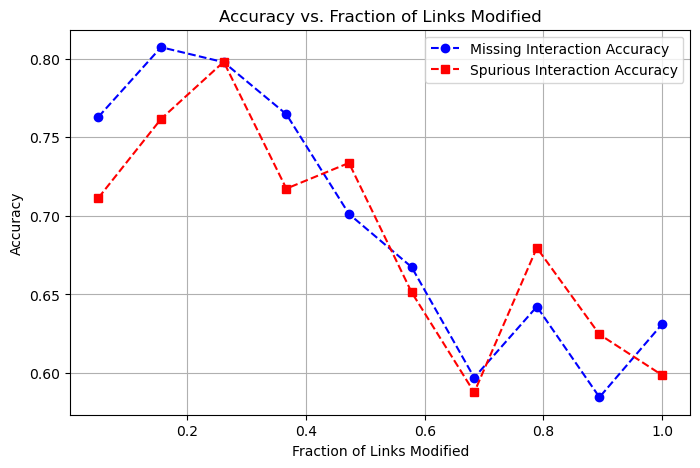

In [4]:
# Define the range of fractions to test
fractions = np.linspace(0.05, 1.0, 10)  # From 5% to 50% in 10 steps

# Store results
missing_accuracies = []
spurious_accuracies = []

# Generate True Network (A_T)
block_sizes = [20, 18, 22]  # Three groups of 4 nodes each
prob_matrix = [[0.8, 0.2, 0.1], [0.2, 0.7, 0.15], [0.1, 0.15, 0.9]]
true_network = generate_block_network(block_sizes, prob_matrix)

for fraction in fractions:
    # Modify network by removing and adding different fractions of links
    observed_network, removed_edges, added_edges = modify_network(true_network, modification_fraction=fraction)

    # Run MCMC Sampling
    partitions = metropolis_MCMC(observed_network, num_samples=1000)

    # Estimate Link Reliability
    reliability = estimate_link_reliability(observed_network, partitions)

    # Calculate Accuracy
    missing_accuracy, spurious_accuracy = calculate_accuracy(true_network, observed_network, reliability)

    # Store results
    missing_accuracies.append(missing_accuracy)
    spurious_accuracies.append(spurious_accuracy)

# Plot Accuracy vs. Fraction of Links Modified
plt.figure(figsize=(8, 5))
plt.plot(fractions, missing_accuracies, label="Missing Interaction Accuracy", marker="o", linestyle="--", color="blue")
plt.plot(fractions, spurious_accuracies, label="Spurious Interaction Accuracy", marker="s", linestyle="--", color="red")

plt.xlabel("Fraction of Links Modified")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Fraction of Links Modified")
plt.legend()
plt.grid()
plt.show()


In [14]:
def calculate_h(A, AO, P, block_counts):
    """Calculate h(A; AO, P) based on the provided formula."""
    l_alpha_beta = {}  # Links in A between groups
    lO_alpha_beta = {}  # Links in AO between groups
    r_alpha_beta = {}  # Maximum possible links between groups

    # Count the number of links between groups in A
    for u, v in A.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        l_alpha_beta[key] = l_alpha_beta.get(key, 0) + 1

    # Count the number of observed links between groups in AO
    for u, v in AO.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO_alpha_beta[key] = lO_alpha_beta.get(key, 0) + 1

    # Count the maximum number of possible links between groups
    for (g1, nodes1), (g2, nodes2) in combinations(block_counts.items(), 2):
        key = tuple(sorted([g1, g2]))
        r_alpha_beta[key] = len(nodes1) * len(nodes2)

    # Add links within the same group
    for g, nodes in block_counts.items():
        key = (g, g)
        r_alpha_beta[key] = len(nodes) * (len(nodes) - 1) // 2

    # Calculate h(A; AO, P)
    h_A_AO_P = 0
    for key, r in r_alpha_beta.items():
        l = l_alpha_beta.get(key, 0)  # Links in A
        lO = lO_alpha_beta.get(key, 0)  # Observed links in AO
        if r > 0:
            term_1 = math.log((r + 1) / (2 * r + 1))
            term_2 = math.log((max(r, 1) * max(l, 1)) / (2 * max(lO, 1) + 1))
            h_A_AO_P += term_1 + term_2

    return np.exp(h_A_AO_P)

def network_reliability(AO, partitions, block_counts):
    """Calculate the network reliability RNA."""
    Z = 0  # Normalization constant
    RNA = {}

    # Ensure that all networks A are proper networkx.Graph objects
    for u, v in combinations(AO.nodes(), 2):  # Iterates over all potential edges
        A = AO.copy()  # Start with a copy of AO
        
        # Simulate edge modification
        if A.has_edge(u, v):
            A.remove_edge(u, v)  # Simulate edge removal
        else:
            A.add_edge(u, v)  # Simulate edge addition

        reliability = 0
        for P in partitions:
            h_A_AO_P = calculate_h(A, AO, P, block_counts)
            H_P = calculate_H(P, AO)  # Ensure `calculate_H` is properly defined
            reliability += h_A_AO_P * np.exp(-H_P)

        RNA[A] = reliability
        Z += reliability  # Update normalization constant

    # Normalize RNA over all possible networks
    for A in RNA:
        RNA[A] /= Z + 1e-10  # Add epsilon to avoid division by zero

    return RNA

def expected_value(AO, RNA, property_func):
    """
    Compute the expected value of a property over all possible networks A.
    property_func: A function X(A) that computes a property of network A.
    """
    expectation = sum(property_func(A) * RNA[A] for A in RNA)
    return expectation

def reconstruct_network(AO, partitions, block_counts, num_samples=100):
    """Reconstruct the network by maximizing RNA."""
    best_RNA = -np.inf
    best_A = AO.copy()

    for _ in range(num_samples):
        # Modify AO randomly
        modified_AO = AO.copy()
        u, v = random.choice(list(combinations(modified_AO.nodes(), 2)))
        
        if modified_AO.has_edge(u, v):
            modified_AO.remove_edge(u, v)  # Remove edge
        else:
            modified_AO.add_edge(u, v)  # Add edge

        # Ensure modified_AO is passed as a graph
        RNA = network_reliability(modified_AO, partitions, block_counts)

        # Check if RNA improved
        current_RNA = sum(RNA.values())  # Total reliability
        if current_RNA > best_RNA:
            best_RNA = current_RNA
            best_A = modified_AO.copy()

    return best_A

# Generate True Network (A_T)
block_sizes = [4, 4, 4]
prob_matrix = [[0.8, 0.2, 0.1], [0.2, 0.7, 0.15], [0.1, 0.15, 0.9]]
true_network = generate_block_network(block_sizes, prob_matrix)

# Create Observed Network (A_O)
observed_network, removed_edges, added_edges = modify_network(true_network, modification_fraction=0.2)

# Run MCMC Sampling
partitions = metropolis_MCMC(observed_network, num_samples=100)

# Get block counts
block_counts = {}
for node, group in initialize_partition(observed_network).items():
    block_counts.setdefault(group, []).append(node)

# Reconstruct the Network
reconstructed_network = reconstruct_network(observed_network, partitions, block_counts)

# Estimate Network Reliability
RNA = network_reliability(observed_network, partitions, block_counts)

# Compute Expected Value of a Property
property_func = lambda A: A.number_of_edges()  # Example: Number of edges
expected_num_edges = expected_value(observed_network, RNA, property_func)

print(f"Expected Number of Edges: {expected_num_edges}")
print(f"Reconstructed Network: {reconstructed_network.edges()}")


Expected Number of Edges: 7.290140815697666e-46
Reconstructed Network: [(0, 4), (1, 3), (1, 7), (1, 5), (2, 3), (3, 4), (4, 5), (4, 7), (5, 9), (6, 9), (7, 9), (8, 10), (8, 11), (9, 10), (9, 11)]


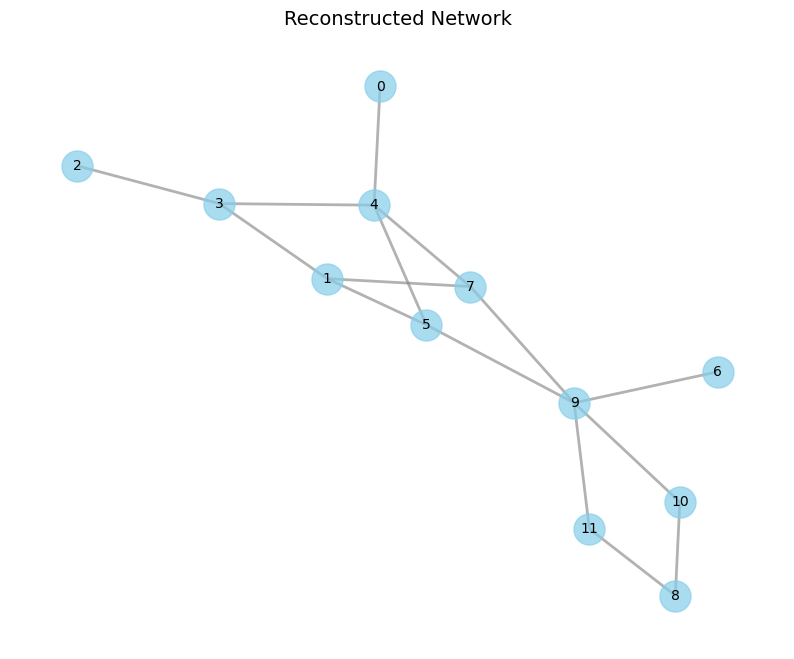

In [15]:
def plot_network(G, title="Network"):
    """
    Function to plot the network using NetworkX and matplotlib.
    
    Parameters:
    - G: NetworkX graph object (the reconstructed network).
    - title: Title of the plot (optional).
    """
    plt.figure(figsize=(10, 8))  # Set figure size
    pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', alpha=0.7)  # Draw nodes
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')  # Draw edges
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')  # Label nodes
    plt.title(title, fontsize=14)
    plt.axis('off')  # Turn off axis for better visualization
    plt.show()

# Plot the reconstructed network
plot_network(reconstructed_network, title="Reconstructed Network")


In [22]:
def property_func(A, AO):
    """Example property: overlap in edges between A and AO."""
    return len(set(A.edges()) & set(AO.edges()))

def expected_value(AO, RNA, property_func):
    """
    Compute the expected value of a property over all possible networks A.
    property_func: A function X(A, AO) that computes a property of network A with AO influence.
    """
    expectation = sum(property_func(A, AO) * RNA[A] for A in RNA)
    return expectation

def similarity_to_AO(A, AO):
    """Calculate similarity between reconstructed network A and observed network AO."""
    shared_edges = len(set(A.edges()) & set(AO.edges()))
    total_edges = len(set(A.edges()) | set(AO.edges()))
    return shared_edges / total_edges if total_edges > 0 else 0

def expected_value_with_similarity(AO, RNA, property_func):
    """
    Compute the expected value of a property over all possible networks A,
    weighted by similarity to AO.
    """
    similarity_weights = {A: similarity_to_AO(A, AO) for A in RNA}
    expectation = sum(property_func(A) * RNA[A] * similarity_weights[A] for A in RNA)
    normalization = sum(RNA[A] * similarity_weights[A] for A in RNA)
    return expectation / normalization  # Normalize by similarity-weighted RNA

# Compute expected value of the edge overlap property
expected_overlap = expected_value(observed_network, RNA, property_func)
print(f"Expected Overlap: {expected_overlap}")

similarity = similarity_to_AO(reconstructed_network, observed_network)
print(f"Similarity to AO: {similarity}")




Expected Overlap: 6.930551421163496e-46
Similarity to AO: 0.9375
